In [1]:
import serial
import numpy as np
from serial.tools import list_ports
import time
import sched

# settings 
INTERVAL = 10          # measure interval in s (> 6)
REPEAT = 3             # number of measurements, 0 = infinite
FILE_NAME = "VNA_Data" # file name, _Y_m_d-H_M_S will be added 

VID = 0x0483 #1155
PID = 0x5740 #22336

# find Nano VNA port
def getport() -> str:
    device_list = list_ports.comports()
    for device in device_list:
        if device.vid == VID and device.pid == PID:
            return device.device
    raise OSError("device not found")
    
# read data from Nano VNA
def readData(ser):
    result = ''
    line = ''
    while True:
        c = ser.read().decode('utf-8')

        if c == '\r':
            next # ignore CR
        line += c
        if c == '\n':
            result += line
            line = ''
            next
        if line.endswith('ch> '):
            # stop on prompt
            break
    return result

# trigger and read frequency vector from Nano VNA
def getFrequencies(ser):
    ser.write(b'frequencies\r')
    ser.flush()

    frequencies = readData(ser)
    frequencies = np.array([float(line) for line in frequencies.split('\n')[1:] if line])
    return frequencies

# trigger and read values array from Nano VNA
def getData(ser):
    ser.write(b'data\r')
    ser.flush() 

    data = readData(ser)
    x = []
    for line in data.split('\n')[1:]:
        if line:
            d = line.strip().split(' ')
            x.append(float(d[0])+float(d[1])*1.j)
    data = np.array(x)
    return data

# convert array with complex data to flat string
def complexDataToString(complexArray):
    return ';;'.join([f'{x.real};{x.imag}i' for x in complexArray]) + ';;\n'

# convert vector with data to flat string
def frequenciesToString(frequencVector):
    return ';;;'.join([f'{x}' for x in frequencVector]) + ';;;\n'

In [2]:
comport = getport()
with serial.Serial(comport) as ser:  # connect to port
    frequencies = getFrequencies(ser) # read frequency vector

    # save frequency vector to file
    timestr = time.strftime("%Y_%m_%d-%H_%M_%S")
    filename = f'{FILE_NAME}_{timestr}.txt'
    with open(filename, "w") as file:
        content = ';' + frequenciesToString(frequencies)
        file.write(content)

        # collect data and save to file
        n = 0
        starttime = time.time() # get start time to calc delay
        while True:
            # print(time.time()) # debug output to check interval
            data = getData(ser)
            Z = 50*(1 + data)/(1 - data) # calc impedance
            content = time.strftime("%H:%M:%S") +';'+ complexDataToString(Z)
            file.write(content)
            n += 1
            print(n)
            if REPEAT != 0:
                if n >= REPEAT:
                    break
            # print(INTERVAL - ((time.time() - starttime) % INTERVAL))    # debug to check interval size
            time.sleep(INTERVAL - ((time.time() - starttime) % INTERVAL)) # calc delay 

1
2
3


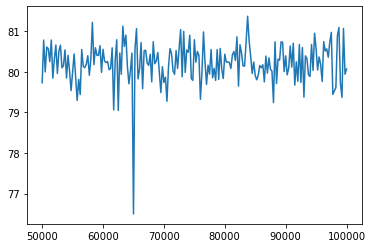

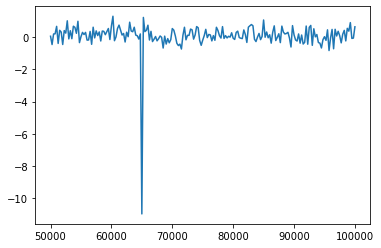

In [3]:
comport = getport()
ser = serial.Serial(comport)

frequencies = getFrequencies()
data = getData()

ser.close()

Z = 50*(1 + data)/(1 - data)

realPartZ = [ele.real for ele in Z]
imgPartZ = [ele.imag for ele in Z]

plt.plot(frequencies, realPartZ)
plt.show()

plt.plot(frequencies, imgPartZ)
plt.show()